Text(0, 0.5, 'y')

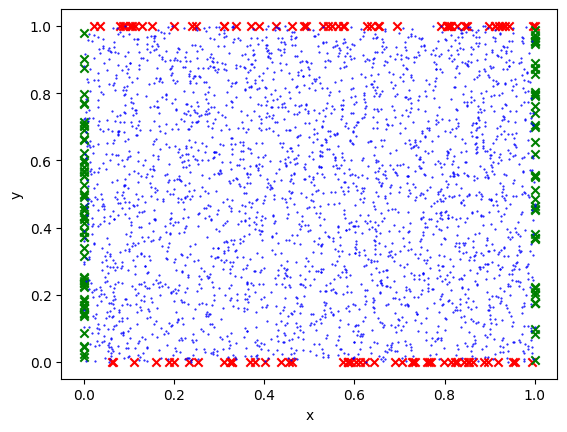

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.enable_eager_execution()

pi = np.pi

# Initial Condition
def BC_u(x, y):
    n = x.shape[0]
    return tf.zeros((n,1))

#Boundary Conditions
def BC_v(x, y):
    n = x.shape[0]
    return tf.zeros((n,1))

#PDE Residual
def Integral(u_x, v_y, w_x, eig_value, N, t):
    return tf.square(u_x + v_y + w_x)*t - eig_value*N*tf.square(w_x)*t

def sy(y):
  return y*(y-ymax)

def sx(x):
  return -0.6917*x*(x-xmax)

def sw(x,y):
  return 0.1750*x*(x-xmax)*y*(y-ymax)

#Boundary Data
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0

lb = tf.constant([xmin, ymin])
ub = tf.constant([xmax, ymax])

# Number of points data points
N_0 = 100 # At time t=0 i.e. IC
N_b = 100 # At boundaries i.e. at x=1 and x=-1
N_r = 3000 # Collocation Points

tf.random.set_seed(10)

# Assuming uniform sampling for IC (Usually Latin Hyprcube Sampling done)
# t_0 = tf.ones((N_0,1)) * tmin
# x_0 = tf.random.uniform((N_0,1), xmin, xmax)
# X_0 = tf.concat([t_0, x_0], axis=1)
# u_0 = IC(x_0)

x_bu = tf.random.uniform((N_b,1), xmin, xmax)
y_bu = ymin + (ymax - ymin) * tf.keras.backend.random_bernoulli((N_b,1), 0.5)
u_bu = BC_u(x_bu, y_bu)
t_bu = tf.ones((N_b, 1))*0.01
n_bu = tf.ones((N_b, 1))*1
X_bu = tf.concat([x_bu, y_bu, n_bu, t_bu], axis=1)

# Assuming uniform sampling for BC (Usually Latin Hyprcube Sampling done)
y_bv = tf.random.uniform((N_b,1), ymin, ymax)
x_bv = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((N_b,1), 0.5)
u_bv = BC_v(x_bv, y_bv)
t_bv = tf.ones((N_b, 1))*0.01
n_bv = tf.ones((N_b, 1))*1
X_bv = tf.concat([x_bv, y_bv, n_bv, t_bv], axis=1)

# Assuming Uniform Sampling inside the domain
x_r = tf.random.uniform((N_r,1), xmin, xmax)
y_r = tf.random.uniform((N_r,1), ymin, ymax)
n_r = tf.ones((N_r, 1))*1
t_r = tf.ones((N_r, 1))*0.01
X_r = tf.concat([x_r, y_r, n_r, t_r], axis=1)

# print(X_r.shape)

# Collect boundary and inital data in lists
# X_data = [X_bu, X_bv]
# Y_data = [y_bu, y_bv]
# t_data = [t_bu, t_bv]
# n_data = [n_bu, n_bv]
# u_data = [u_bu, u_bv]
# v_data = [u_bu, u_bv]
# w_data = [u_bu, u_bv]
X_data_1 = [X_bu]
X_data_2 = [X_bv]
u_data = [u_bu]
v_data = [u_bu]
w_data = [u_bu]

# figure=plt.figure(figsize=(16,9))
plt.scatter(x_bu, y_bu, c='r', marker='x')
plt.scatter(x_bv, y_bv, c='g', marker='x')
plt.scatter(x_r, y_r, c='b', marker='.', s=1)

plt.xlabel('x')
plt.ylabel('y')


In [ ]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=40):

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(4,)) # Input is two-dimensional (time + one spatial dimension)

    #scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer) # Introduce a scaling layer to map input to [lb, ub]

    for _ in range(num_hidden_layers): # Append hidden layers
        model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(120, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(64, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(16, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(64, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(120, activation=tf.keras.activations.get('tanh')))
        model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.get('tanh')))

    model.add(tf.keras.layers.Dense(4)) # Output is one-dimensional (Value of u)

    return model

In [ ]:
from scipy.interpolate import interp2d
from scipy.integrate import dblquad
from scipy.interpolate import RegularGridInterpolator

In [ ]:
# Function for Residual

def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, y = X_r[:, 0:1], X_r[:, 1:2]

        N = X_r[:, 2:3]
        t = X_r[:, 3:4]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)
        tape.watch(y)

        # Determine residual # Forward Propogation
        out = model(tf.stack([x[:,0], y[:,0], N[:,0], t[:,0]], axis=1))

        u = out[:, 0]
        v = out[:, 1]
        w = out[:, 2]
        eig_value = out[:, 3]
        # print(out.shape)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        v_y = tape.gradient(v, y)
        w_x = tape.gradient(w, x)

    del tape

    z = Integral(u_x, v_y, w_x, eig_value, N, t)


    result = tf.reduce_mean(z)*ymax*xmax
    #result += tf.math.reduce_mean(eig_value - 60.57)
    result += tf.math.reduce_mean(u - sx(x))
    result += tf.math.reduce_mean(v - sy(y))
    result += tf.math.reduce_mean(w - sw(x,y))


    print("Result shape: {}".format(result.shape))

    return result

In [ ]:
# Function for Loss

def compute_loss(model, X_r, X_data_1, X_data_2, u_data, v_data, w_data):

    # Compute Collocation Point Loss
    # r = get_r(model, X_r)
    # phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = get_r(model, X_r)

    # Add IC Loss and BC Loss to the loss
    for i in range(len(X_data_1)):
      x, y = X_r[:, 0:1], X_r[:, 1:2]

      N = X_r[:, 2:3]
      t = X_r[:, 3:4]

      out1 = model(X_data_1)
      u_pred_1 = out1[:, 0]
      v_pred_1 = out1[:, 1]
      w_pred_1 = out1[:, 2]

      out2 = model(X_data_2)
      u_pred_2 = out2[:, 0]
      v_pred_2 = out2[:, 1]
      w_pred_2 = out2[:, 2]

      loss += tf.reduce_mean(tf.square(v_data - v_pred_1))
      loss += tf.reduce_mean(tf.square(u_data - u_pred_2))
      loss += tf.reduce_mean(tf.square(w_data - w_pred_1))
      loss += tf.reduce_mean(tf.square(w_data - w_pred_2))

      # out = model(tf.stack([x[:,0], y[:,0], N[:,0], t[:,0]], axis=1))  # X_data[i], Y_data[i], n_data[i], t_data[i])
      # u_pred = out[:, 0]
      # v_pred = out[:, 1]
      # w_pred = out[:, 2]
      # loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
      # loss += tf.reduce_mean(tf.square(v_data[i] - v_pred))
      # loss += tf.reduce_mean(tf.square(w_data[i] - w_pred))

    return loss

In [ ]:
# Gradient of Loss Function

def get_grad(model, X_r, X_data_1, X_data_2, u_data, v_data, w_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = (compute_loss(model, X_r, X_data_1, X_data_2, u_data, v_data, w_data))

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
model = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data_1, X_data_2, u_data, v_data, w_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # print(loss.shape)
    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('Epoch {}:\t loss = {}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Result shape: ()
Epoch 0:	 loss = -0.5778632164001465
Epoch 50:	 loss = -0.5778632760047913
Epoch 100:	 loss = -0.5778630971908569
Epoch 150:	 loss = -0.5778635740280151
Epoch 200:	 loss = -0.5778626799583435
Epoch 250:	 loss = -0.577862560749054
Epoch 300:	 loss = -0.5778635740280151
Epoch 350:	 loss = -0.5778626799583435
Epoch 400:	 loss = -0.5778622627258301
Epoch 450:	 loss = -0.5778634548187256
Epoch 500:	 loss = -0.5778632164001465
Epoch 550:	 loss = -0.5778626799583435
Epoch 600:	 loss = -0.5778620839118958
Epoch 650:	 loss = -0.5778634548187256
Epoch 700:	 loss = -0.5778627395629883
Epoch 750:	 loss = -0.577862560749054
Epoch 800:	 loss = -0.577863335609436
Epoch 850:	 loss = -0.5778632164001465
Epoch 900:	 loss = -0.5778626203536987
Epoch 950:	 loss = -0.5778627395629883
Epoch 1000:	 loss = -0.5778632760047913
Epoch 1050:	 loss = -0.5778629779815674
Epoch 1100:	 loss = -0.5778617262840271
Epoch 1150:	 loss = -0.5778642296791077
Epoch 1200:	 loss = -0.5778630971908569
Epoch 125

In [ ]:
out = model.predict(X_r)

NameError: ignored

In [ ]:
out.shape
dis = np.sqrt(np.square(out[:,0]) + np.square(out[:,1]) + np.square(out[:,2]))

-3399.6433


Text(0, 0.5, 'y')

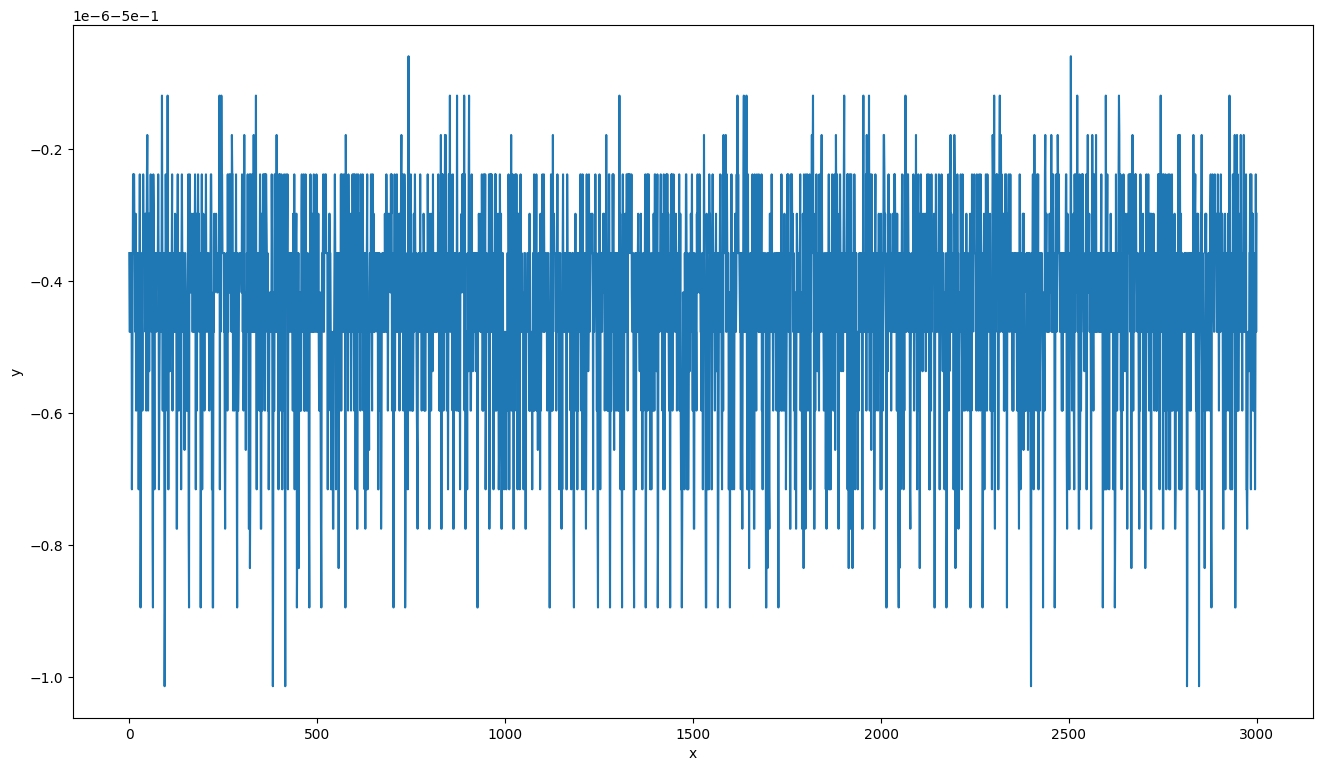

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

figure=plt.figure(figsize=(16,9))
X, Y = np.meshgrid(X_r[:,0], X_r[:,1])
#dis = dis.reshape(X_r[:,0].shape)
# plt.scatter(x_bu, y_bu, c='r', marker='x')
# plt.scatter(x_bv, y_bv, c='g', marker='x')
plt.plot(out[:,0])

print(out[1,3])
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
2

2